In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)  
# DC Motor example (PID tuning)

In [5]:
# DC Motor example (PID tuning)
class DC_motor():
    
    def __init__(self):
        
        b = 0.1  # friction coefficient ( Nm/(rad/sec) )
        I = 0.01 # mechanical inertia (Kg*m^2)
        k = .1 # motor torque constant (Nm/A)
        R = 1    # armature resistance (Ohm)
        L = 0.5  # armature inductance (H)
        
        self.A = np.array([[-b/I, k],[-k/L, -R]])
        self.B = np.array([[0],[1]])
        self.C = np.array([[1,0]])
        
        self.dt = 0.001
        
        
    def ctrl(self, ref, y , Kp = 1, Ki = 0, Kd = 0):
        err = ref - y
        if self.ref_history is None:
            self.ref_history = np.array([ref])
        else:
            self.ref_history = np.append(self.ref_history, np.array([ref]))
        
        self.err_integral += err*self.dt
        u =  Kp*err + Ki * self.err_integral + Kd * (err-self.err_z1)/self.dt
        self.err_z1 = err
        return u
        
        
    def reset(self):
        self.x = np.zeros((2,1))
        self.x_history = None
        self.ref_history = None
        
        self.err_z1 = 0
        self.err_integral = 0
        
        
    def step(self, u):
        
        dot_x = np.matmul(self.A,self.x) + self.B * u
        self.x += dot_x*self.dt
        
        if self.x_history is None:
            self.x_history = self.x.T
            self.u_history = np.array([u])
        else:
            self.x_history = np.append(self.x_history, self.x.T, axis = 0)
            self.u_history = np.append(self.u_history, np.array([u]))
        
        
    def performance_meas(self):
        
        time = np.arange(self.x_history.shape[0])*self.dt
        rt_idx = min(np.where( np.abs(self.x_history[:,0] - self.ref_history)< 0.1 )[0])
        ss_values_idx = np.where( np.abs(self.x_history[:,0] - self.x_history[-1,0] )<0.005 )[0]
        ss_values_idx = [ idx for i, idx in enumerate(ss_values_idx) if abs(idx - ss_values_idx[min(i+1, len(ss_values_idx)-1)]) < 2 ]
        st_idx = min(ss_values_idx)
        
        rt = round(time[rt_idx],3)
        ss_err = round(np.abs(self.x_history[-1,0] - self.ref_history[-1]),3)
        os = round(max(self.x_history[:,0])-self.ref_history[-1],3)
        st = round(time[st_idx],3)
        
        print(f'rise time: {rt}')
        print(f'overshoot: {os}')
        print(f'settling time: {st}')
        print(f'steady state error: {ss_err}')
        
        return rt, os, st, ss_err
        
    def render(self):
        t = np.arange(self.x_history.shape[0])*self.dt
        fig, ax = plt.subplots(3,1)
        ax[0].plot(t,self.x_history[:,0], t,self.ref_history)
        ax[0].set(ylabel = 'motor speed')
        ax[1].plot(t,self.x_history[:,1])
        ax[1].set(ylabel = 'current')
        ax[2].plot(t,self.u_history)
        ax[2].set(ylabel = 'voltage (control input)')    
    

rise time: 0.366
overshoot: 0.086
settling time: 0.38
steady state error: 0.01


(0.366, 0.086, 0.38, 0.01)

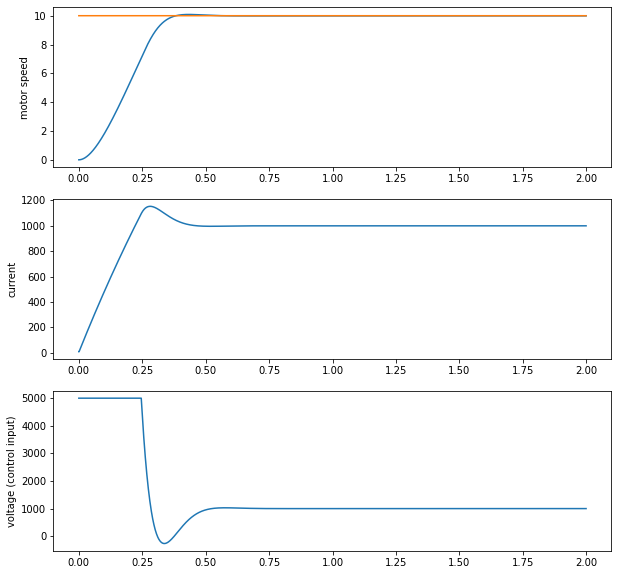

In [18]:
mot = DC_motor()
mot.reset()
T_end = 2
ref = 10
sat = 5000

Kp = 4000
Ki = 500
Kd = 200


#Kp = 8000
#Ki = 1000
#Kd = 200

for _ in range(round(T_end/mot.dt)):

    mot_speed = mot.x[0]
    u = mot.ctrl(ref, mot_speed, Kp , Ki , Kd )

    u = np.clip(u,-sat,sat)
    mot.step(u)

mot.render()    
mot.performance_meas()
    